In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random

import splitfolders
import pathlib
import cv2
import os
import PIL

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

#### Data Loading

In [49]:
ds_path = 'C:/Users/aa10098/Downloads/Rice/Rice_Image_Dataset_100'
ds_path = pathlib.Path(ds_path)

#### Splitting the Dataset into 3 Subsets; training, testing, validating

In [66]:
splitfolders.ratio(ds_path, output='imgs_100', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 500 files [00:01, 432.53 files/s]


In [52]:
arborio = [fn for fn in os.listdir(f'{ds_path}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{ds_path}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{ds_path}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{ds_path}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{ds_path}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs_100/train'):
    rice_classes+=[i]
rice_classes.sort()

#### Data Exploration

Total images: 500
Total number of classes: 5
Total Arborio images: 100
Total Basmati images: 100
Total Ipsala images: 100
Total Jasmine images: 100
Total Karacadag images: 100


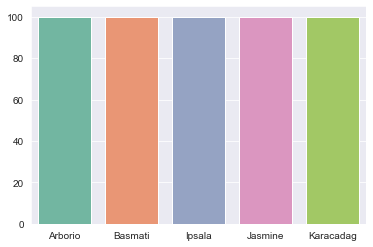

In [53]:
image_count = len(list(ds_path.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Set2")
plt.show()

Rice Image Dimensions are: (250, 250, 3)


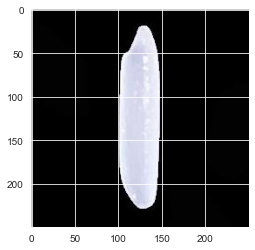

In [55]:
rice_img = cv2.imread('C:/Users/aa10098/Downloads/Rice/Rice_Image_Dataset_100/Basmati/basmati (14).jpg')
rice_img = cv2.cvtColor(rice_img, cv2.COLOR_BGR2RGB)
plt.imshow(rice_img)
print(f"Rice Image Dimensions are: {rice_img.shape}")

#### Data Pre_Processing

In [56]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [57]:
img_generator = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest')

In [59]:
ds_train = img_generator.flow_from_directory('imgs_100/train',
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             subset = "training",
                                             class_mode='categorical')
ds_validate = img_generator.flow_from_directory('imgs_100/val',
                                          target_size = (img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode='categorical',
                                          shuffle=False)
ds_test = img_generator.flow_from_directory('imgs_100/test',
                                      target_size = (img_height, img_width),
                                      batch_size = batch_size,
                                      class_mode='categorical',
                                      shuffle=False)

Found 350 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


#### Model Building

In [60]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = input_shape, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))


In [63]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 173, 173, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 173, 173, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 173, 173, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 173, 173, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 87, 87, 32)       0         
 2D)                                                             
                                                      

In [64]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [65]:
fitting = model.fit(ds_train, epochs = 40,  
                    validation_data = ds_validate,
                    callbacks = callbacks) 

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 2.3487 - accuracy: 0.2686 
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to saved_models\model_vanilla.hdf5
3/3 [==============================] - 48s 18s/step - loss: 2.3487 - accuracy: 0.2686 - val_loss: 1.6140 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.4514 
Epoch 2: val_accuracy did not improve from 0.20000
3/3 [==============================] - 41s 13s/step - loss: 1.3650 - accuracy: 0.4514 - val_loss: 2.0395 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.5686 
Epoch 3: val_accuracy did not improve from 0.20000
3/3 [==============================] - 41s 13s/step - loss: 1.0723 - accuracy: 0.5686 - val_loss: 2.6853 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.6486 
Ep

#### Model Evaluation

In [40]:
score1 = model.evaluate(ds_test, verbose=1)
print(f'Model Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')

1/1 [==============================] - 2s 2s/step - loss: 3.0793 - accuracy: 0.2267
Model Vanilla Loss: 3.079319953918457, Accuracy: 22.66666740179062


1/1 [==============================] - 2s 2s/step


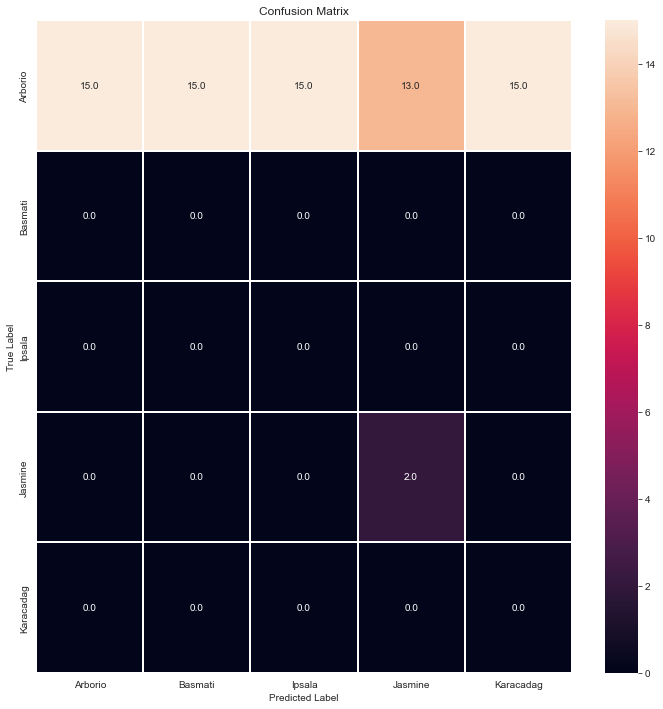

In [46]:
Y_pred = model.predict(ds_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, ds_test.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(ds_test.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()